# Projet radiologie bootcamp DST : Etape 2, Preprocessing

### Plan de preprocessing : 
* Ouvrir chaque image avec son masque associé
* Convertir en Grayscale
* Redimensionner les images à la taille des masques (256 * 256)
* Appliquer les masques
* Equilibrer le nouveau dataset
* Séparer le dataset en ensemble d'entraînement (70%), de validation (15%) et de test (15%)

In [1]:
#Import des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import os, pathlib
from tqdm import tqdm
import cv2
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import shutil #pour copier des fichiers vers les dossiers de preprocessing

### Etape 1 : création des images masquées et en échelles de gris
* Ouvrir chaque image en grayscale en itérant sur les dossiers
* Ouvrir le masque associé en grayscale
* Resizer l'image en 256*256
* Appliquer le masque
* Enregistrer l'image dans un nouveau dossier

### Pour le test du 21/12, un nouveau préprocessing ajouté avec 
* Application d'un filtre Gaussien
* Application d'une égalisation d'histogramme

In [7]:
#Sous-fonction qui ouvre une image à partir du filepath, la convertit en Grayscale et la redimensionne en 256*256
#En input : le filepath d'une image dans le dossier "image" => plutôt retravailler le masque
def load_and_resize(file):
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    #Ajout pour test du 21/12 : fonctions de GaussianBlur et Histogram Equalization
    img = cv2.equalizeHist(img)
    img = cv2.GaussianBlur(img, (3,3), 0)
    return img

#Sous-fonction qui va chercher le masque et le convertit en Grayscale
#En input : le filepath d'une image dans le dossier "image" qui est l'input de la fonction finale
def load_mask(file):
    mask_path = file.replace("images","masks")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    #Test 28/12 : Ajout d'une fonction pour inverser le masque et obtenir la zone hors poumons
    mask = cv2.bitwise_not(mask)
    #retourner le masque
    return mask

#Fonction qui applique le masque et enregistre l'image ainsi préprocessée dans un nouveau dossier
#Input : image et masque (données d'origine), nom du fichier et chemin du dossier cible pour l'enregistrement
def get_masked_imgs(sourceimg, nom_cible, dossier_cible):
    img_resized = load_and_resize(sourceimg)
    mask = load_mask(sourceimg)
    img_masked = cv2.bitwise_and(img_resized, mask)
    cv2.imwrite(os.path.join(dossier_cible, nom_cible), img_masked)


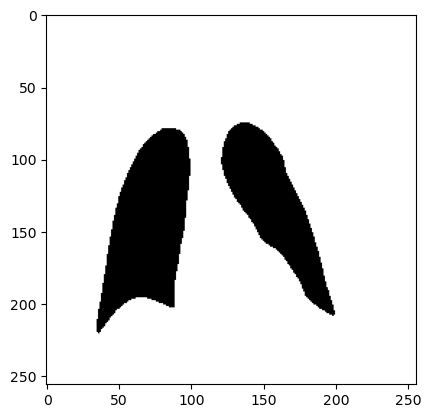

In [13]:
mask  = "../data/Sourcedata/COVID/masks/COVID-1001.png"
plt.imshow(load_mask(mask), cmap = "gray")

In [14]:
#Test sur 1 fichier
fichier = "../data/Sourcedata/COVID/images/COVID-1001.png"
nom_cible = os.path.split(fichier)[1]
dossier_cible = "../data/"

get_masked_imgs(fichier, nom_cible, dossier_cible)



#print(img_resized.shape)
#print(mask.shape)
#plt.figure(figsize=(15, 5))
#plt.subplot(131)
#plt.imshow(img_resized, cmap = "Greys_r")
#plt.subplot(132)
#plt.imshow(mask, cmap = "Greys_r")
#plt.subplot(133)
#plt.show()

In [15]:
#Définition des dossiers d'origine et cible, et lancement des fonctions => voir le script python dans SRC
class_list = ["COVID", "Viral_Pneumonia", "Lung_Opacity", "Normal"]
#class_list = ["Normal"]
#dossiers_source_dict = {"COVID" : "../data/COVID/images/", "NORMAL" : "../data/Normal/images/", "VIRAL_PNEUMONIA" : "../data/Viral Pneumonia/images/", "LUNG_OPACITY" : "../data/Lung_Opacity/images/" }
dossier_source = "../data/Sourcedata/"
dossier_cible = "../data/Preprocess_inversemask/"

#Itérer sur les dossiers pour récupérer les fichiers images
for class_ in class_list:
    source_dir_path = os.path.join(dossier_source,class_,"images/")
    target_dir_path = os.path.join(dossier_cible, class_)
    for f in tqdm(os.listdir(source_dir_path)):
        nom_cible = f
        file = os.path.join(source_dir_path, f)
        get_masked_imgs(file, nom_cible, target_dir_path)




  0%|          | 7/3616 [00:00<00:54, 65.64it/s]

100%|██████████| 10192/10192 [7:04:00<00:00,  2.50s/it]      


## Etape 2 : Equilibrage des classes par sous-échantillonage


In [22]:
#Import de la base excel metadata
meta_Covid = pd.read_excel("../data/COVID.metadata.xlsx")
meta_Covid.insert(loc = 0, column="CLASS", value =  "COVID")
meta_Normal = pd.read_excel("../data/Normal.metadata.xlsx")
meta_Normal.insert(loc = 0, column="CLASS", value =  "NORMAL")
meta_VPneu = pd.read_excel("../data/Viral Pneumonia.metadata.xlsx")
meta_VPneu.insert(loc = 0, column="CLASS", value =  "VIRAL_PNEUMONIA")
meta_LO = pd.read_excel("../data/Lung_Opacity.metadata.xlsx")
meta_LO.insert(loc = 0, column="CLASS", value =  "LUNG_OPACITY")
#Fusion des 4 metafichiers dans un dataframe
metadata = pd.concat([meta_Covid, meta_LO, meta_Normal, meta_VPneu], axis = 0)
#Enregistrement en csv
metadata.to_csv("../data/metadata_compil.csv")

In [32]:
#Nb de valeurs par classe dans metadata
print(len(metadata))
metadata["CLASS"].value_counts()

#Utilisation d'un RandomUnderSampler pour équilibrer le dataset
ru = RandomUnderSampler(random_state = 123, replacement = False)
meta_ru, y_ru = ru.fit_resample(metadata, metadata["CLASS"])
meta_ru.head()
meta_ru["CLASS"].value_counts()

21165


COVID              1345
LUNG_OPACITY       1345
NORMAL             1345
VIRAL_PNEUMONIA    1345
Name: CLASS, dtype: int64

In [42]:
meta_ru["CLASS"].value_counts().sum()

5380

In [50]:
## Sélection aléatoire et enregistrement des fichiers dans les dossiers TRAIN (70%), VALIDATE (15%), TEST (15%)
# Séparation jeu de TRAIN à 70/30
meta_TRAIN, meta_TESTVAL, y1, y2 = train_test_split(meta_ru, y_ru, test_size = 0.3, random_state = 123, stratify = y_ru)

#Séparation du jeu de VALIDATION et TEST à 50/50
meta_VAL, meta_TEST, y3, y4 = train_test_split(meta_TESTVAL, y2, test_size = 0.5, random_state = 123, stratify = y2)

print("meta Train :\n", meta_TRAIN["CLASS"].value_counts())
print("meta VAL :\n", meta_VAL["CLASS"].value_counts())
print("meta TEST :\n", meta_TEST["CLASS"].value_counts())
meta_TRAIN.head()

meta_TRAIN["SET"] = "TRAIN"
meta_VAL["SET"] = "VAL"
meta_TEST["SET"] = "TEST"
meta_dataset = pd.concat([meta_TRAIN, meta_VAL, meta_TEST], axis = 0)
meta_dataset["SET"].value_counts()


meta Train :
 VIRAL_PNEUMONIA    942
COVID              942
NORMAL             941
LUNG_OPACITY       941
Name: CLASS, dtype: int64
meta VAL :
 LUNG_OPACITY       202
VIRAL_PNEUMONIA    202
NORMAL             202
COVID              201
Name: CLASS, dtype: int64
meta TEST :
 NORMAL             202
COVID              202
LUNG_OPACITY       202
VIRAL_PNEUMONIA    201
Name: CLASS, dtype: int64


TRAIN    3766
VAL       807
TEST      807
Name: SET, dtype: int64

## Etape 3 : enregistrement des 3 datasets dans 3 sous-dossiers TRAIN, VAL, TEST du dossier PREPROCESSING_2

In [43]:
meta_dataset.head()

,CLASS,FILE NAME,FORMAT,SIZE,URL,SET
4080,VIRAL_PNEUMONIA,Viral Pneumonia-46,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...,TRAIN
1106,COVID,COVID-2461,PNG,256*256,https://bimcv.cipf.es/bimcv-projects/bimcv-cov...,TRAIN
4244,VIRAL_PNEUMONIA,Viral Pneumonia-210,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...,TRAIN
5306,VIRAL_PNEUMONIA,Viral Pneumonia-1272,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...,TRAIN
1058,COVID,COVID-1693,PNG,256*256,https://bimcv.cipf.es/bimcv-projects/bimcv-cov...,TRAIN


In [46]:
dossier_source = "..\\data\\Preprocessing_1"
dossiers_cibles_dict = {"TRAIN" : "..\\data\\Preprocessing_2\Train", "VAL" : "..\\data\\Preprocessing_2\Train", "TEST" : "..\\data\\Preprocessing_2\Train"}

#Fonction pour copier les fichiers dans le dossier cible
def copy_to_folder(filename, source_folder, target_folder):
    filename = filename + ".png"
    #chemin d'accès au fichier soruce
    src = os.path.join(source_folder, filename)
    #chemin d'accès du fichier copié
    dst = os.path.join(target_folder, filename)
    #copie
    shutil.copyfile(src, dst)

#Itération sur les noms de fichiers retenus par le TRAIN TEST SPLIT
for index, row in tqdm(meta_dataset.iterrows()):
    dossier_cible = dossiers_cibles_dict[row["SET"]]
    copy_to_folder(row["FILE NAME"], dossier_source, dossier_cible)

5380it [01:45, 50.92it/s]


## Création du jeu de donnée préprocessé et équilibré

Principe : 
- à partir du jeu d'images préprocessé (Préprocessing_1)
- On part du nombre minimal d'échantillons par classe : 1345 (5380 images au total)
- On met de côté 15% des images pour le test (pas fourni au modèle) : 800 (200 par classe), avec équilibre des classes
- On copie 4 jeux :
    - 400 images (100*4)
    - 1000 images (250 * 4)
    - 2000 images (500 * 4)
    - 4000 images (1000 * 4) 
    - Toutes les images : 4576 (1144/classe), arrondi

Noms : Train_set_400, Train_set_1000, Train_set_2000, Train_set_4000, Train_set_4576, Test_set_800

In [3]:
#Nombre d'échantillons de la classe la moins représentée : 1345
metadata = pd.read_csv("../data/metadata_compil.csv")
metadata.head()
metadata["CLASS"].value_counts()

NORMAL             10192
LUNG_OPACITY        6012
COVID               3616
VIRAL_PNEUMONIA     1345
Name: CLASS, dtype: int64

In [11]:
#Créer les dossiers cibles #a marché mais ils n'apparaissent pas dans Windows... a la mano !
dossier_racine = "../../data/"
dossiers_a_creer = ["Train_set_400", "Train_set_1000", "Train_set_2000", "Train_set_4000", "Train_set_4580", "Test_set_800"]
for dossier in dossiers_a_creer:
    new_dossier = os.path.join(os.path.abspath(dossier_racine), dossier)
    os.makedirs(new_dossier)
    for sousdossier in ["NORMAL", "COVID", "LUNG OPACITY" , "VIRAL PNEUMONIA"]:
        new_sousdossier = os.path.join(new_dossier, sousdossier)
        os.makedirs(new_sousdossier)
print(os.listdir(dossier_racine))

    

FileExistsError: [WinError 183] Impossible de créer un fichier déjà existant: 'c:\\Users\\thiba\\Documents\\Projets data\\data\\Train_set_400'

In [14]:
#On vérifie
print(os.listdir(dossier_racine))
print(os.listdir(os.path.join(dossier_racine,"Train_set_1000")))


['Preprocessing_1', 'Test_set_800', 'Train_set_1000', 'Train_set_2000', 'Train_set_400', 'Train_set_4000', 'Train_set_4580']
['COVID', 'LUNG OPACITY', 'NORMAL', 'VIRAL PNEUMONIA']


In [28]:
#à partir du total 1345/classe
#On copie 4 jeux :
#    - 400 images (100*4)
#    - 1000 images (250 * 4)
#    - 2000 images (500 * 4)
#    - 4000 images (1000 * 4) 
#    - Toutes les images : 4580 (1145/classe)



#Nécessite de calculer l'équilibre des classes en amont
def extract_subset(dossier_source, dossier_cible_train, dossier_cible_test, nb_img_train_par_classe:int, nb_img_test_par_classe:int):
    #Parcourir les dossiers du dataset préprocessé
    for c in os.listdir(dossier_source):
        #parcourir chaque classe 
        classe = os.path.join(dossier_source, c)
        #Créer un array randomisé et séparer en TRAIN/TEST d'après le pct de split
        #boucle sur un array randomisé entre 1 et le nombre d'images total à extraire pour chaque classe
        nb_total_img_a_extraire = nb_img_train_par_classe + nb_img_test_par_classe
        random_array = np.random.choice(os.listdir(classe), nb_total_img_a_extraire, replace = False)
        #Extraction du jeu de TEST en prenant les X premiers fichiers randomisés
        for file in tqdm(random_array[:nb_img_test_par_classe]):
            #chemin d'accès au fichier soruce
            src = os.path.join(classe, file)
            #chemin d'accès du fichier copié
            dst = os.path.join(dossier_cible_test, c, file)
            #copie
            shutil.copyfile(src, dst)
        #Extraction du jeu de TRAIN
        for file in tqdm(random_array[nb_img_test_par_classe:]):
            #chemin d'accès au fichier soruce
            src = os.path.join(classe, file)
            #chemin d'accès du fichier copié
            dst = os.path.join(dossier_cible_train, c, file)
            #copie
            shutil.copyfile(src, dst)
        


In [23]:
#On fait tourner la fonction pour tester
dossier_source = "../../../Projets data/Projet-radio-DST_TG/data/test2/" 
dossier_cible_train = "../../../Projets data/Projet-radio-DST_TG/data/test3/Train"
dossier_cible_test = "../../../Projets data/Projet-radio-DST_TG/data/test3/Test"
extract_subset(dossier_source, dossier_cible_train, dossier_cible_test, 2, 1)


100%|██████████| 2/2 [00:00<00:00, 450.85it/s]


In [35]:
# D'abord on isole un jeu de test (15% = 201 imgs/classe) et un set d'entraînement "MAX" à partir du jeu d'images préprocessé  
dossier_source = "../data/Preprocessing_1/"
dossier_cible_train = "../data/Train_set_4576/"
dossier_cible_test = "../data/Test_set_800/"
extract_subset(dossier_source, dossier_cible_train, dossier_cible_test, 1144, 201)


 20%|██        | 41/201 [00:00<00:00, 368.11it/s]

100%|██████████| 1144/1144 [00:03<00:00, 373.29it/s]


In [37]:
#Ensuite on créée des jeux de test réduits à partir du jeu complet pour tester les différentes test sizes
#400
for i in [400]:
    dossier_source = "../data/Train_set_4576/"
    dossier_cible_train = "../data/Train_set_" + str(i)
    dossier_cible_test = "../data/"
    extract_subset(dossier_source, dossier_cible_train, dossier_cible_test, i//4, 0)

0it [00:00, ?it/s]
100%|██████████| 100/100 [00:00<00:00, 103.97it/s]
0it [00:00, ?it/s]
100%|██████████| 100/100 [00:00<00:00, 112.46it/s]
0it [00:00, ?it/s]
100%|██████████| 100/100 [00:00<00:00, 106.99it/s]
0it [00:00, ?it/s]
100%|██████████| 100/100 [00:01<00:00, 96.53it/s]


In [38]:
for i in [1000, 2000, 4000]:
    dossier_source = "../data/Train_set_4576/"
    dossier_cible_train = "../data/Train_set_" + str(i)
    dossier_cible_test = "../data/"
    extract_subset(dossier_source, dossier_cible_train, dossier_cible_test, i//4, 0)

0it [00:00, ?it/s]
100%|██████████| 250/250 [00:02<00:00, 98.24it/s] 
0it [00:00, ?it/s]
100%|██████████| 250/250 [00:03<00:00, 82.15it/s] 
0it [00:00, ?it/s]
100%|██████████| 250/250 [00:02<00:00, 104.04it/s]
0it [00:00, ?it/s]
100%|██████████| 250/250 [00:02<00:00, 90.00it/s] 
0it [00:00, ?it/s]
100%|██████████| 500/500 [00:06<00:00, 80.89it/s] 
0it [00:00, ?it/s]
100%|██████████| 500/500 [00:07<00:00, 69.17it/s] 
0it [00:00, ?it/s]
100%|██████████| 500/500 [00:04<00:00, 108.96it/s]
0it [00:00, ?it/s]
100%|██████████| 500/500 [00:04<00:00, 110.39it/s]
0it [00:00, ?it/s]
100%|██████████| 1000/1000 [00:05<00:00, 181.36it/s]
0it [00:00, ?it/s]
100%|██████████| 1000/1000 [00:05<00:00, 177.04it/s]
0it [00:00, ?it/s]
100%|██████████| 1000/1000 [00:05<00:00, 178.32it/s]
0it [00:00, ?it/s]
100%|██████████| 1000/1000 [00:06<00:00, 148.18it/s]


In [39]:
#Tous les jeux sont bons pour les prochains modèms

# Nouvelle extraction d'un jeu à 2O OOO images suite aux tests de modèles

In [16]:
#Paramètres
dataset_preprocess_path = "../data/Preprocess_inversemask/"
target_folder = "../data/Dataset_inversemask/"

dataset_preprocess_dir = pathlib.Path(dataset_preprocess_path).with_suffix('')
target_dir = pathlib.Path(target_folder).with_suffix('')
class_dir = list(dataset_preprocess_dir.glob('*'))

# Vérification nombre d'images dans le set de preprocess
print ("Répertoire  : ", dataset_preprocess_dir)
train_set_image_count = len(list(dataset_preprocess_dir.glob('*/*.png')))
print("Nombre images set ", train_set_image_count)

# Vérification nombre d'images par classe
for class_ in class_dir:
    print ("Répertoire  : ", class_)
    image_count = len(list(class_.glob("*.png")))
    print("Nombre images set ", image_count)



Répertoire  :  ..\data\Preprocess_inversemask
Nombre images set  21165
Répertoire  :  ..\data\Preprocess_inversemask\COVID
Nombre images set  3616
Répertoire  :  ..\data\Preprocess_inversemask\Lung_Opacity
Nombre images set  6012
Répertoire  :  ..\data\Preprocess_inversemask\Normal
Nombre images set  10192
Répertoire  :  ..\data\Preprocess_inversemask\Viral_Pneumonia
Nombre images set  1345


In [17]:
#Je choisis de créer un dataset aligné sur la classe COVID : 3616 images par classe répartie aléatoirement entre Train et Test avec 20% test.
#La classe Viral Pneumonia est celle qui obtient les meilleurs scores de classification, on peut donc copier aléatoirement des images pour compléter le jeu sans risquer de dégrader la perf sur cette classe
# Définir le nombre d'images à piocher dans le set complet pour équilibrer les classes
#nb_img_par_classe = 3616
nb_img_par_classe = 1345

test_ratio = 0.2
nb_img_cible_test = round(nb_img_par_classe * test_ratio)
nb_img_cible_train = nb_img_par_classe - nb_img_cible_test
print("Nb images par classe TRAIN : ", nb_img_cible_train, " \nNb images par classe TEST : ", nb_img_cible_test)

Nb images par classe TRAIN :  1076  
Nb images par classe TEST :  269


In [18]:
#Récupérer les noms des classes
class_list = [str(i).rsplit("\\", 1)[1] for i in class_dir] 
print(class_list)

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']


In [ ]:
#Approche choisie : augmenter le jeu de données baseline existant : 
# - Piocher des images en plus dans le dataset préprocessé initial jusqu'à atteindre 3616
# - Pour Viral Pneumonia, copier des images des datasets existants 
#ceci afin d'éviter de mélanger des images Train et Test

In [19]:
# create class directories : OK

for label in class_list:
    for subfolder in ["Train/", "Test/"]:
        ds_folder = target_folder + subfolder + label
        if not os.path.exists(ds_folder):
            os.mkdir(ds_folder)

# set the destination target
#label_df['path'] = label_df['class'].astype(str) + os.path.sep + label_df['image']

# copy or move files
#for _, row in label_df.iterrows():
    # shutil.copy(row['image'], row['path'])
#    shutil.move(row['image'], row['path'])

In [20]:
#Fonction pour itérer sur les classes et copier le nombre d'images voulues dans un dossier cible avec un split entre Train et Test 
for class_ in class_dir:

    #extraire le nom de la classe
    class_name = str(class_).rsplit("\\", 1)[1]
    print(class_name) 

    #Définir le dossier cible
    target_train_folder = pathlib.Path(target_folder + "Train/" + class_name).with_suffix('')
    target_test_folder = pathlib.Path(target_folder + "Test/" + class_name).with_suffix('')

    #Extraire la liste des images dans le set source préprocessé 
    img_path_list = list(class_.glob('*.png'))
    print("Nombre d'images de la classe dans le set préprocessé : ", len(img_path_list)) 
    #Extraire les noms des images depuis les "path"
    img_names_list_source = [str(i).rsplit("\\", 1)[1] for i in img_path_list]


    #Initialisation d'un array sans remise, taille = nombre d'images cible
    random_array = np.random.choice(img_names_list_source, min(nb_img_par_classe,len(img_path_list)) , replace = False)

    #Extraction du jeu de TEST en prenant les 20% premières images de l'array randomisé
    test_size = round(nb_img_par_classe * test_ratio)
    for file in tqdm(random_array[:test_size]):
        #chemin d'accès au fichier soruce
        src = os.path.join(class_, file)
        #chemin d'accès du fichier copié
        dst = os.path.join(target_test_folder, file)
        #copie
        shutil.copyfile(src, dst)

    #Extraction du jeu de TRAIN
    for file in tqdm(random_array[test_size:]):
        #chemin d'accès au fichier soruce
        src = os.path.join(class_, file)
        #chemin d'accès du fichier copié
        dst = os.path.join(target_train_folder, file)
        #copie
        shutil.copyfile(src, dst)
        



#Itérer sur les classes


    #Extraire la liste des images dans le dossier source, afficher le nombvre


 #   train_dir = 
 #   train_dir_list = 
 #   test_dir = 
 #   test_dir_list =



COVID
Nombre d'images de la classe dans le set préprocessé :  3616


  0%|          | 0/269 [00:00<?, ?it/s]

100%|██████████| 1076/1076 [00:48<00:00, 22.17it/s]


Lung_Opacity
Nombre d'images de la classe dans le set préprocessé :  6012


100%|██████████| 1076/1076 [01:09<00:00, 15.51it/s]


Normal
Nombre d'images de la classe dans le set préprocessé :  10192


100%|██████████| 1076/1076 [00:55<00:00, 19.32it/s]


Viral_Pneumonia
Nombre d'images de la classe dans le set préprocessé :  1345


100%|██████████| 1076/1076 [01:23<00:00, 12.88it/s]


In [64]:
# On accepte moins d'images dans le jeu d'entraînement Viral_Pneumonia, car la perf est déjà bonne